In [30]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [31]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-17 12:15:45.102006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 12:15:45.120810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 12:15:45.122249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 12:15:45.122531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 12:15:45.122822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10822269349272900175
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5592514560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 625770865599315383
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [32]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/All_cases_100x100_tips_PredictionBased.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
# train_index = np.sort(indexes[int(0.25 * data_sz) :])
# val_index = np.sort(indexes[: int(0.25 * data_sz)])
# train_index = np.sort(indexes[np.concatenate((np.arange(0,int(0.25 * data_sz)), np.arange(int(0.5 * data_sz),len(indexes))), axis=0)])
# val_index = np.sort(indexes[int(0.25 * data_sz) : int(0.5 * data_sz)])

In [33]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(6230, 100, 100, 2)

In [34]:
x_train, y_train = [np.expand_dims(train_dataset[:,:,:,0],3),np.expand_dims(train_dataset[:,:,:,1],3)]
x_val, y_val = [np.expand_dims(val_dataset[:,:,:,0],3),np.expand_dims(val_dataset[:,:,:,1],3)]

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (4672, 100, 100, 1), (4672, 100, 100, 1)
Validation Dataset Shapes: (1558, 100, 100, 1), (1558, 100, 100, 1)


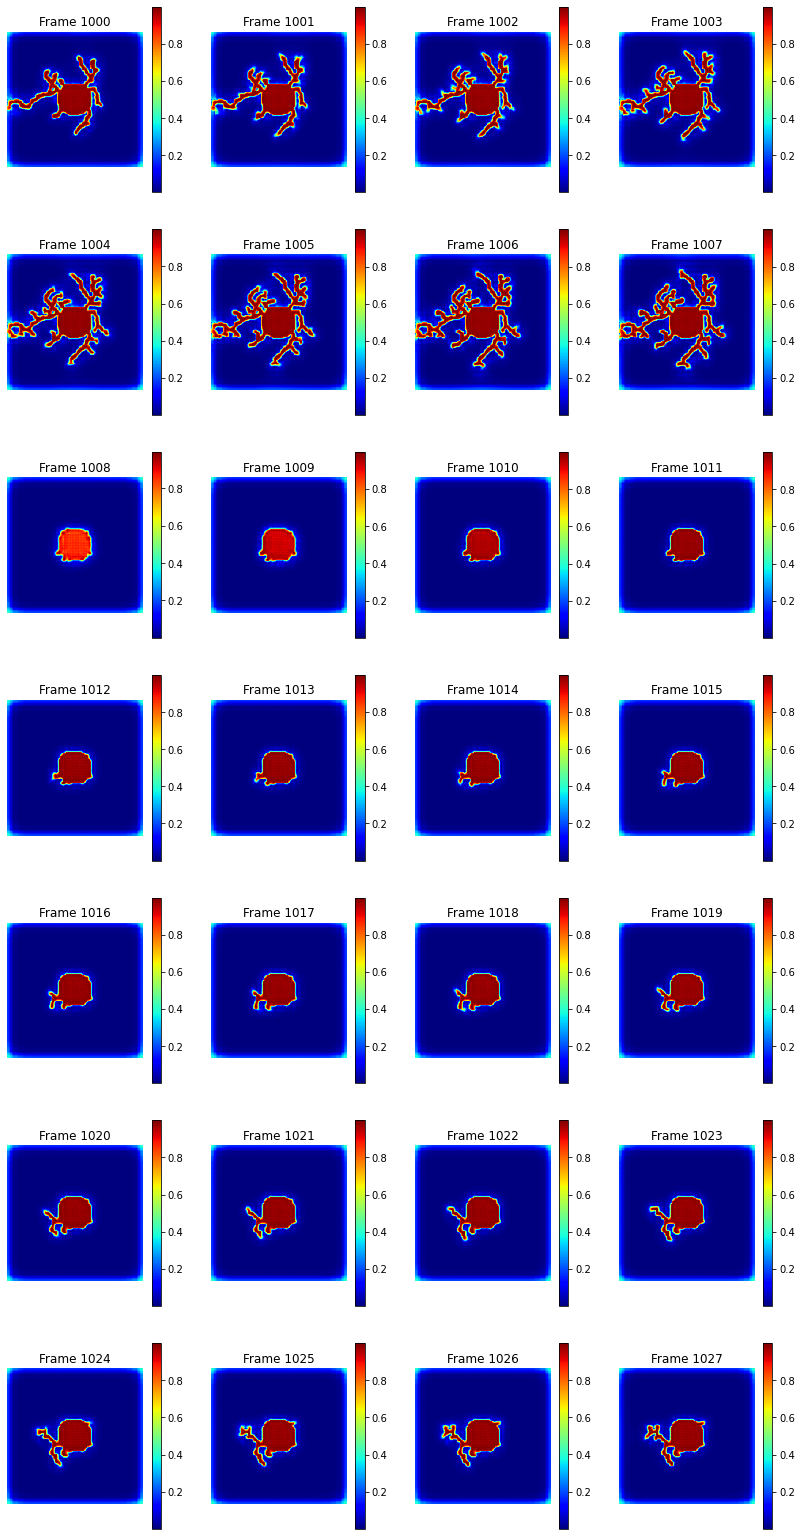

In [35]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(x_train[idx+1000,:,:],cmap='jet')
    plt.title(f"Frame {idx+1000}")
    plt.axis("off")
    plt.colorbar()
plt.show()

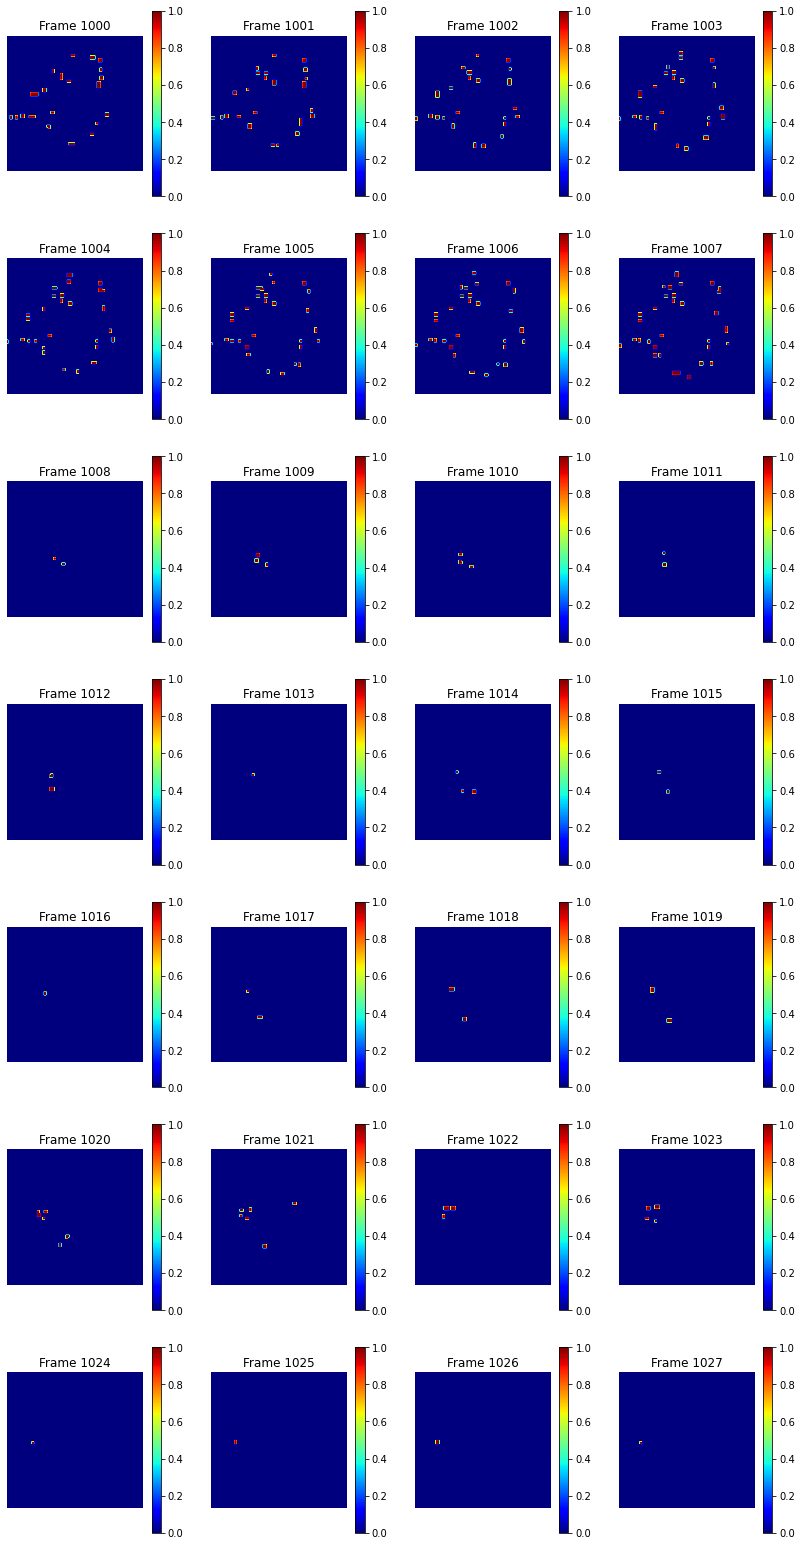

In [36]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(y_train[idx+1000,:,:],cmap='jet')
    plt.title(f"Frame {idx+1000}")
    plt.axis("off")
    plt.colorbar()
plt.show()

In [37]:
# inp = layers.Input(shape=(None, *x_train.shape[2:]))
inp = layers.Input(shape=(x_train.shape[1:]))

drop_rate = 0.1
x0 = layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(inp)
x0 = layers.Dropout(drop_rate)(x0)
x0 = layers.BatchNormalization()(x0)
x1 = layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(x0)
x1 = layers.Dropout(drop_rate)(x1)
x1 = layers.BatchNormalization()(x1)
x2 = layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(x1)
x2 = layers.Dropout(drop_rate)(x2)
x2 = layers.BatchNormalization()(x2)
x3 = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
)(x2)
x3 = layers.Dropout(drop_rate)(x3)
x3 = layers.BatchNormalization()(x3)

In [38]:
from keras import backend as K
def customLoss(yTrue, yPred):
    return K.max(K.abs(yTrue - yPred))

In [39]:
model = keras.models.Model(inp, x3)
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    # loss=customLoss,
    optimizer=keras.optimizers.Adam(learning_rate=1e-5))
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 dropout_8 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       204928    
                                                                 
 dropout_9 (Dropout)         (None, 22, 22, 128)       0         
                                                           

In [40]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_tipsCNN_predBased_4fold0')
else:
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 2000
    batch_size = 16

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            # callbacks=[early_stopping, reduce_lr],
        )
    model.save('./saved_model/model_tipsCNN_predBased_4fold0') 

Epoch 1/2000
292/292 [==============================] - 3s 8ms/step - loss: 0.9733 - val_loss: 0.0178
Epoch 2/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.9629 - val_loss: 0.0194
Epoch 3/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.9559 - val_loss: 0.0325
Epoch 4/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.9494 - val_loss: 0.0348
Epoch 5/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.9428 - val_loss: 0.0268
Epoch 6/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.9361 - val_loss: 0.0283
Epoch 7/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.9292 - val_loss: 0.0339
Epoch 8/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.9219 - val_loss: 0.0422
Epoch 9/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.9143 - val_loss: 0.0435
Epoch 10/2000
292/292 [==============================] - 2s 7ms/step - loss: 0.905

KeyboardInterrupt: 

In [41]:
    model.save('./saved_model/model_tipsCNN_predBased_4fold0') 

INFO:tensorflow:Assets written to: ./saved_model/model_tipsCNN_predBased_4fold0/assets


INFO:tensorflow:Assets written to: ./saved_model/model_tipsCNN_predBased_4fold0/assets


1/1 [==============================] - 0s 75ms/step


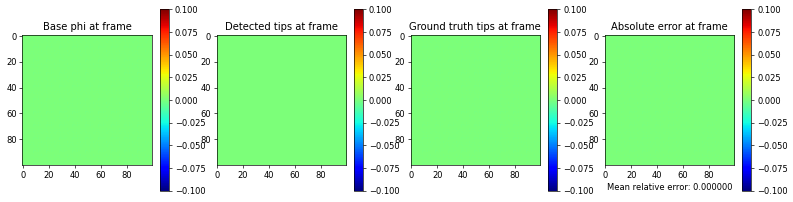

1/1 [==============================] - 0s 11ms/step


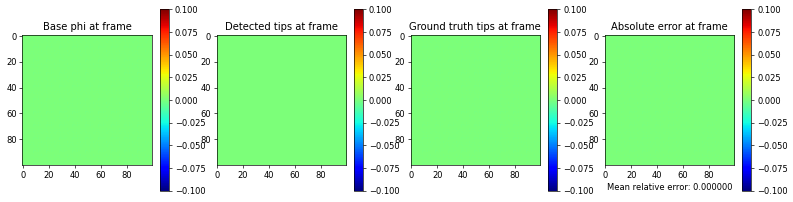

1/1 [==============================] - 0s 11ms/step


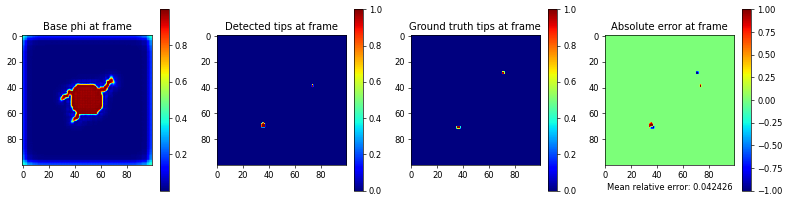

1/1 [==============================] - 0s 12ms/step


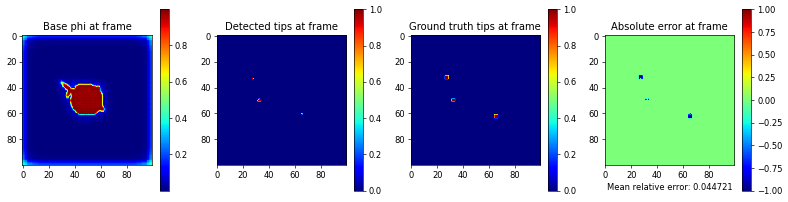

1/1 [==============================] - 0s 12ms/step


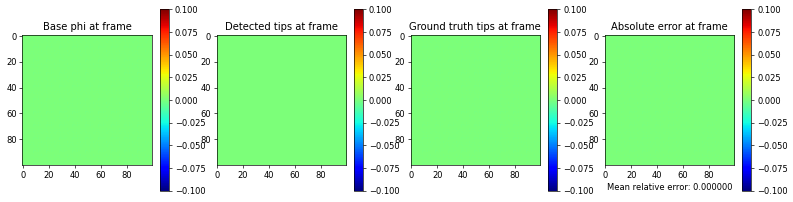

1/1 [==============================] - 0s 13ms/step


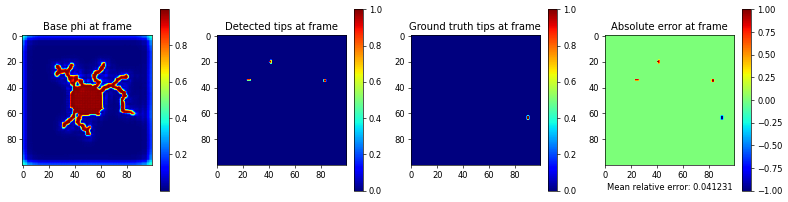

1/1 [==============================] - 0s 13ms/step


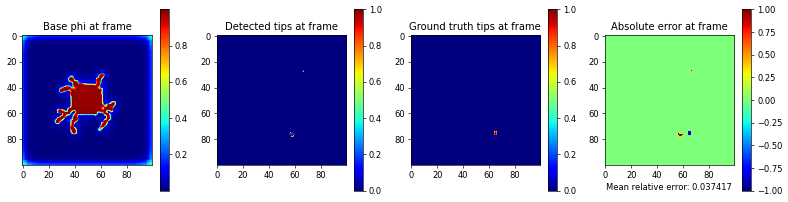

1/1 [==============================] - 0s 14ms/step


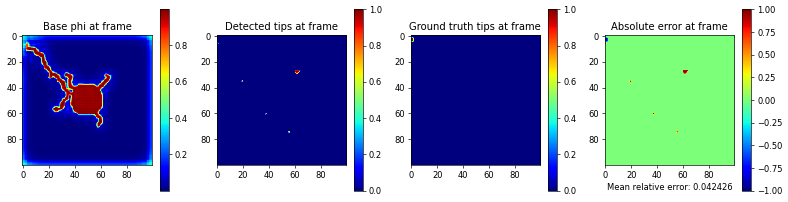

1/1 [==============================] - 0s 14ms/step


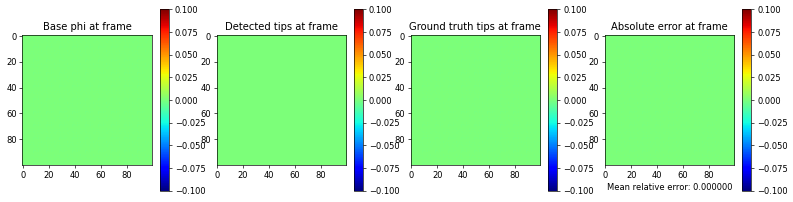

1/1 [==============================] - 0s 15ms/step


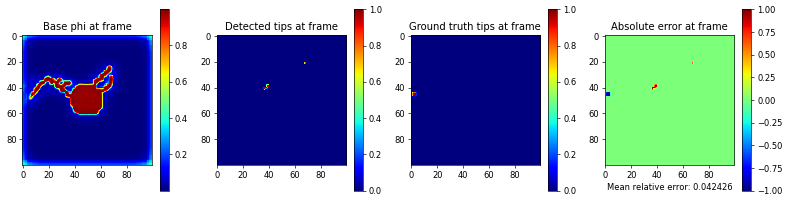

In [42]:
def push(input, cutoff):
    max_input = np.amax(input)
    input[input>cutoff*max_input] = 1
    input[input<=cutoff*max_input] = 0
    return input
    
for i in range(10):
    rand_case = np.random.randint((len(val_dataset)))

    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]

    x_in = np.expand_dims(example_x,axis=0)

    tips = push(model.predict(x_in),0.5)
    # tips = model.predict(x_in)

    mre = np.sqrt(np.sum(np.square(tips[0,:,:,0]-example_y[:,:,0])/(tips.shape[1]*tips.shape[2])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,4,1)
    plt.imshow(example_x[:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Base phi at frame')

    plt.subplot(1,4,2)
    plt.imshow(tips[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Detected tips at frame')

    plt.subplot(1,4,3)
    plt.imshow(example_y[:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth tips at frame')

    plt.subplot(1,4,4)
    plt.imshow(tips[0,:,:,0]-example_y[:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame')
    plt.xlabel('Mean relative error: %f'%mre)

    plt.show()

In [43]:
from tqdm import tqdm

mre = []
for rand_case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]

    x_in = np.expand_dims(example_x,axis=0)

    tips = push(model.predict(x_in, verbose="0"),0.5)
    # tips = model.predict(x_in, verbose="0")

    mre.append(np.sqrt(np.sum(np.square(tips[0,:,:,0]-example_y[:,:,0])/(tips.shape[1]*tips.shape[2]))))

print(sum(mre) / len(mre))

Running ...: 100%|██████████| 1558/1558 [00:42<00:00, 36.98it/s]

0.03580338733899336


In [ ]:
fold0=0.03580338733899336
fold1=0.06921912918472593
fold2=0.07272690198416168
fold3=0.07296504905440314


SyntaxError: invalid syntax (2162198269.py, line 1)